# Explore spatial averaging on horizontal yagi antenna

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 22/1/2023

+ FEKO data provided by Danie Ludick
+ Uses **v11** RFcalcUC module
+ This notebook uses dataframes in HDF5 files that were generated from the `make_HDF5_Hyagi_v2.ipynb` notebook

## Load necessary python modules

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
from copy import deepcopy
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

# PARAMETERS
  # Set general public limit values at 900 MHz
SLIM_WB_PUB = 4.5  # W/m²
SARLIM_PUB = 0.08  # W/kg
  # Letters
LETTERS = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

## Look at model metadata for the spatial averaging trials

In [2]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials.loc[:,['unit','2','3']]

,unit,2,3
INPUT,,,
fMHz,MHz,900,900
antenna,,IEC 62232 panel antenna,Yagi
Prad,W,200,100
dBiGain,,,
horizHPBW,deg,,
vertHPBW,deg,,
coordinate_origin,,centre of the middle feed segment,centre of rear reflector
xstart,m,-1,-1
xend,m,14,5


## Create the RFc object for the analyses
The class for this object is in the `RFcalcUC_v11.py` file

In [3]:
# Set trial number
trial = 3
t = trials[str(trial)]

In [4]:
# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 100 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [0, 0.48]
yb = [-0.1, 0.1]
zb = [-0.05, 0.05]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)
R

datadir = '../antennas/Hyagi/data/'
plotdir = '../antennas/Hyagi/plots/'


Object parameters:
  900 MHz, 100 W
  errtol = 0.15
  offset = 0 m
  default length of spatial averagering window = 1.6 m
  152,561 grid points
  nx = 61, ny = 41, nz = 61

In [5]:
# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print(*R.grid.items(),sep='\n')

Sfile='../antennas/Hyagi/data/Hyagi.hdf5'


,x,y,z,r,phi,SE,SH,Smax,SARwbi
0,-1.0,-2.0,-3.0,2.236068,-116.565051,0.161726,0.161659,0.161726,NaN
1,-1.0,-2.0,-2.9,2.236068,-116.565051,0.165805,0.165718,0.165805,NaN
2,-1.0,-2.0,-2.8,2.236068,-116.565051,0.169610,0.169503,0.169610,NaN
3,-1.0,-2.0,-2.7,2.236068,-116.565051,0.173072,0.172948,0.173072,NaN
4,-1.0,-2.0,-2.6,2.236068,-116.565051,0.176124,0.175984,0.176124,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}

('x', [-1, 5, 0.1])
('y', [-2, 2, 0.1])
('z', [-3, 3, 0.1])


In [6]:
# Create filters for valid 1.6m and 2m spatial averaging points
fsa16 = R.sf('spatavg', spatavgL=1.6) # valid 1.6m spatial averaging points
fsa20 = R.sf('spatavg', spatavgL=2.0) # valid 2.0m spatial averaging points
fsa06 = R.sf('spatavg', spatavgL=0.6) # valid 0.6m spatial averaging points
foutant = R.sf('outant', offset=0)    # all points outside antenna box

# Show invalid points for 1.6m spatial aveargaing, i.e. where 1.6m body intersects antenna
# RFcalcUC.show_grid_points(R.S[~fsa16.mask], fields=['SE'],hman=None,axv=(False,False,False),
#                           antcolor='yellow',bgcolor='white',antenna=RFcalcUC.hyagi,title='0.2m outant')

## Create general filters

In [7]:
# Calculate wavelength, λ
wl = 300 / R.freq
d = round(wl, 2)

# exclude high and low points that aren't properly averaged
f0 = R.sf('(z >= -2.2) & (z <= 2.2)') 
f1 = R.sf('(z >= -2.0) & (z <= 2.0)') 

# points within one λ of antenna (near field)
f_near = R.sf('ant', offset=d, setting='pub', power=100)

# points further than one λ from antenna (far field)
f_far = R.sf('outant', offset=d, setting='pub', power=100)

# valid 1.6m spatial averaging points
f_sa16 = R.sf('spatavg', offset=0.001, spatavgL=1.6)

# valid 2.0m spatial averaging points
f_sa20 = R.sf('spatavg', offset=0.001, spatavgL=2.0)

# valid 0.6m spatial averaging points
f_sa06 = R.sf('spatavg', offset=0.001, spatavgL=0.6)

# all points outside antenna box
f_outant = R.sf('outant', offset=0.001)

# valid points in near field (<= 1λ)
f_outantnear = deepcopy(f_outant)
f_outantnear.mask = f_outantnear.mask & f_near.mask
f_outantnear.name += ' (near field)'

# valid 1.6m spatial averaging points (near field & far field)
f_sa16nearfar = deepcopy(f_sa16)
f_sa16nearfar.mask = f_sa16nearfar.mask & f0.mask
f_sa16nearfar.name += ' (near & far field)'

# valid 1.6m spatial averaging points <= 1λ from antenna (near field)
f_sa16near = deepcopy(f_sa16)
f_sa16near.mask = (f_sa16near.mask & f0.mask) & f_near.mask
f_sa16near.name += ' (near field)'

# valid 1.6m spatial averaging points > 1λ from antenna (far field)
f_sa16far = deepcopy(f_sa16)
f_sa16far.mask = (f_sa16far.mask & f0.mask) & f_far.mask
f_sa16far.name += ' (far field)'

# valid 2.0m spatial averaging points (near field & far field)
f_sa20nearfar = deepcopy(f_sa20)
f_sa20nearfar.mask = f_sa20nearfar.mask & f1.mask
f_sa20nearfar.name += ' (near & far field)'

# valid 2.0m spatial averaging points <= 1λ from antenna (near field)
f_sa20near = deepcopy(f_sa20)
f_sa20near.mask = (f_sa20near.mask & f1.mask) & f_near.mask
f_sa20near.name += ' (near field)'

# valid 2.0m spatial averaging points > 1λ from antenna (far field)
f_sa20far = deepcopy(f_sa20)
f_sa20far.mask = (f_sa20far.mask & f1.mask) & f_far.mask
f_sa20far.name += ' (far field)'

def make_16m_cb_filter(Si, errtol, power):
    '''Create a filter for valid 1.6m spatially averaged points
       where Si is within the error tolerance of the public limit
       for the nominated radiated power of the antenna'''
    f_sa16_cb = deepcopy(f_sa16)
    f_cb = R.sf('cb', setting='pub', data=Si, offset=0.001,
                errtol=errtol, spatavgL=1.6, power=power, standard='RPS S-1 WB')
    f_sa16_cb.mask = f_sa16_cb.mask & f_cb.mask
    f_sa16_cb.name = 'Valid ' + f_sa16_cb.name
    return f_sa16_cb

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 200W radiated power
f_sa16_cb200W = make_16m_cb_filter('Smax', 0.15, 200)

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 150W radiated power
f_sa16_cb150W = make_16m_cb_filter('Smax', 0.15, 150)

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 100W radiated power
f_sa16_cb100W = make_16m_cb_filter('Smax', 0.15, 100)

# valid 1.6m spatial averaging points where Smax is within +/-15% of pub limit
# at 50W radiated power
f_sa16_cb50W = make_16m_cb_filter('Smax', 0.15, 50)

replacing z with S.z --> (S.z >= -2.2) & (S.z <= 2.2)
meval: (S.z >= -2.2) & (S.z <= 2.2)
replacing z with S.z --> (S.z >= -2.0) & (S.z <= 2.0)
meval: (S.z >= -2.0) & (S.z <= 2.0)


In [8]:
# Show mask points
f = f_outantnear
# f = f_outant
# f = f_outant
print(f.name)
RFcalcUC.show_grid_points(R.S[f.mask], fields=['SE'],hman=None,axv=(True,True,True), ycut=True,
                          antcolor='yellow',bgcolor='white',antenna=RFcalcUC.hyagi,title=f.name)

points outside 0.001m offsetted antenna box (near field)


## Data checks

In [9]:
# Display the horizontal antenna
fig = mlab.figure(1, size=(1200,900), 
                  bgcolor=(1,1,1),
                  fgcolor=(0,0,0))
mlab.clf()
RFcalcUC.vyagi('yellow')

# draw the axes
ax = mlab.axes(x_axis_visibility=False, y_axis_visibility=False, z_axis_visibility=False,
               color=(0,0,0))

# Draw the scene
fig.scene.parallel_projection = True
mlab.show()

### Show S and SAR grids

In [10]:
R.S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152561 entries, 0 to 152560
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       152561 non-null  float64
 1   y       152561 non-null  float64
 2   z       152561 non-null  float64
 3   r       152561 non-null  float64
 4   phi     152561 non-null  float64
 5   SE      152561 non-null  float64
 6   SH      152561 non-null  float64
 7   Smax    152561 non-null  float64
 8   SARwbi  102541 non-null  float64
dtypes: float64(9)
memory usage: 10.5 MB


### View public and occ compliance zones

In [11]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.ExclusionZone(
    data=["SE", "SE"],
    power=[100, 100],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    antenna=RFcalcUC.hyagi,
    axv=[True,False,True]
)

dat='SE', con=4.5
dat='SE', con=22.5
[-0.3, 4.6, -1.3, 1.3, -1.6, 1.8]
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=occupational, limit=22.5 W/m², contour level=22.500


In [12]:
# Animated 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.AnimatedExclusionZone(
    data=["SE", "SE"],
    power=[50, 50],
    color=["gold", "red"],
    alpha=[0.5, 0.5],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    ycut=0,
    daz=-0.1,
    elevation = 80,
    distance=None,
    title="",
    figsize=(1200,800),
    antenna=RFcalcUC.hyagi,
    axv=[False,False,False]
)

dat='SE', con=9.0
dat='SE', con=45.0
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000
power=100, plotpower=50, setting=occupational, limit=22.5 W/m², contour level=45.000


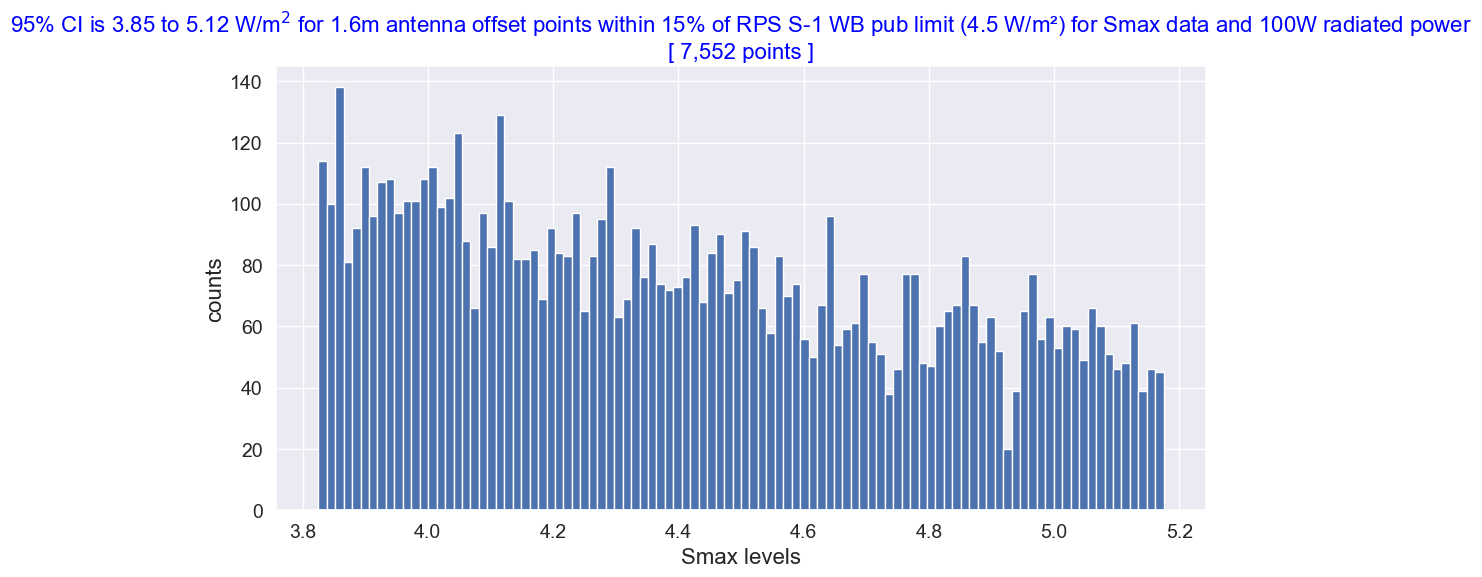

In [13]:
# Show SARwbi histogram
f = fsa16
f = R.sf('cb', offset=1.6, setting='pub')
R.hist(data='Smax', f=f, bins=100)

## Create spatially averaged fields
Create some new S columns for vertical spatial averaging

**c** is the convolution vector applied to z columns of points for each (x,y) group

In [14]:
def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

In [15]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
for m in [17,9,5,3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
creating SE-1.6m-17 spatial average of SE
creating Smax-1.6m-17 spatial average of Smax

 9 points: sum[0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111] = 1.0000000000000002
creating SE-1.6m-9 spatial average of SE
creating Smax-1.6m-9 spatial average of Smax

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating SE-1.6m-5 spatial average of SE
creating Smax-1.6m-5 spatial average of Smax

 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-1.6m-3 spatial average of SE
creating Smax-1.6m-3 spatial average of Smax


In [16]:
# 1.6m vertical average curves using Simpsons 1/3 rule
l = 1.6
c17 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
c9  = [1,0,4,0,2,0,4,0,2,0,4,0,2,0,4,0,1]
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c3  = [1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1]
for m,clist in zip([3,5,9,17],[c3,c5,c9,c17]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}-S13", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
    R.spatavg(f"Smax-{l}m-{m}-S13", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3))")


 3 points: sum[0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167] = 0.9999999999999999
creating SE-1.6m-3-S13 spatial average of SE
creating Smax-1.6m-3-S13 spatial average of Smax

 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-1.6m-5-S13 spatial average of SE
creating Smax-1.6m-5-S13 spatial average of Smax

 9 points: sum[0.042, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.042] = 0.9999999999999999
creating SE-1.6m-9-S13 spatial average of SE
creating Smax-1.6m-9-S13 spatial average of Smax

17 points: sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating SE-1.6m-17-S13 spatial average of SE
creating Smax-1.6m-17-S13 spatial average of Smax


In [17]:
# 1.6m vertical average curves using Simpsons 1/3 rule and SH
l = 1.6
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
for m,clist in zip([5],[c5]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SH-{l}m-{m}-S13", "SH", c, title=f"FEKO SH levels ({m} points averaged over {l}m (Simpson 1/3))")


 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SH-1.6m-5-S13 spatial average of SH


In [18]:
# 1.5m vertical average curves using Simpsons 3/8 rule on 7 points
# Note: had to approximate values at 0.25,0.75,1.25 with 
# averages of (0.2,0.3), (0.7,0.8), (1.2,1.3)
l = 1.5
m = 7
dl = l / (m-1)
#      0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5
c6  = [1, 0, 1.5,1.5, 0,  3,  0,  1,  1,  0,  3,  0, 1.5,1.5, 0,  1]
c = (3/8)*(dl/l) * np.array(c6)
print(f'\n{m:2d} points: sum{list(c)} = {sum(c)}')
R.spatavg(f"SE-{l}m-{m}-S38", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 3/8))")
R.spatavg(f"Smax-{l}m-{m}-S38", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 3/8))")


 7 points: sum[0.0625, 0.0, 0.09375, 0.09375, 0.0, 0.1875, 0.0, 0.0625, 0.0625, 0.0, 0.1875, 0.0, 0.09375, 0.09375, 0.0, 0.0625] = 1.0
creating SE-1.5m-7-S38 spatial average of SE
creating Smax-1.5m-7-S38 spatial average of Smax


In [19]:
# 2m vertical average curves
l, dl = 2, 0.1
for m in [3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-2m-3 spatial average of SE
creating Smax-2m-3 spatial average of Smax


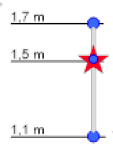

In [20]:
# IEC 62232 spatial averaging scheme (3pts over 0.6m)
c = np.array([1,0,0,0,1,0,1,0,0]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-0.6m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 0.6m)")
R.spatavg(f"Smax-IEC-0.6m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 0.6m)")

len(c) = 9 points: sum[0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333, 0.0, 0.0] = 1.0
creating SE-IEC-0.6m-3 spatial average of SE
creating Smax-IEC-0.6m-3 spatial average of Smax


In [21]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-9': 'FEKO SE levels (9 points averaged over 1.6m)',
 'Smax-1.6m-9': 'FEKO Smax levels (9 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.6m-3-S13': 'FEKO SE levels (3 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-3-S13': 'FEKO Smax levels (3 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-5-S13': 'FEKO SE levels (5 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-5-S13': 'FEKO Smax levels (5 points averaged over 1.6m (Simpson 1/3))',


## Create compliance boundary filters

In [22]:
# Calculate equivalent limits for 100W pub and 25W occ
Slim_highpower_pub = SLIM_WB_PUB
Slim_lowpower_occ =  SLIM_WB_PUB * 5 * (100/25)

def cb_filter(Si):
    f = deepcopy(f_sa16)
    mask = (R.S[Si] >= Slim_highpower_pub) & (R.S[Si] <= Slim_lowpower_occ)
    f.mask = f.mask & mask
    f.name = f'valid points between {Si} pub & occ compliance boundaries for 25<=power<=100W'
    return f

f_Smax_cb25to100W = cb_filter('Smax')
f_Smax_cb25to100W_sa16_17_S13 = cb_filter('Smax-1.6m-17-S13')
f_Smax_cb25to100W_sa16_9_S13 = cb_filter('Smax-1.6m-9-S13')
f_Smax_cb25to100W_sa16_5 = cb_filter('Smax-1.6m-5')
f_Smax_cb25to100W_sa16_3 = cb_filter('Smax-1.6m-3')
f_Smax_cb25to100W_sa16_5_S13 = cb_filter('Smax-1.6m-5-S13')
f_Smax_cb25to100W_sa16_3_S13 = cb_filter('Smax-1.6m-3-S13')

## Compare compliance zones

R essentially indicates the level of over-estimating WBA SAR compliance when conforming with the S limits. R ≥ 1 at an assessment point implies that WBA SAR will be compliant if S is compliant at that point and so it is desirable that R is always greater than or equal to 1.

#### Animated SAR vs 1.6m pt compliance zones

In [67]:
# Animated 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.AnimatedExclusionZone(
    data=["SARwbi", "Smax-1.6m-5"],
    power=[100, 100],
    color=["magenta", "green"],
    alpha=[0.5, 0.5],
    setting=["public", "public"],
    standard=["RPS S-1 WB"] * 2,
    ycut=0,
    daz=-0.1,
    elevation = 80,
    distance=None,
    title="",
    figsize=(1200,800),
    antenna=RFcalcUC.hyagi,
    axv=[False,False,False]
)

dat='SARwbi', con=0.08
dat='Smax-1.6m-5', con=4.5
power=100, plotpower=100, setting=public, limit=0.08 W/kg, contour level=0.080
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500


#### WBA SAR vs all S settings

In [68]:
# Compare SAR, Smax
n = 6
R.ExclusionZone(
    data=["SARwbi","Smax","Smax-1.6m-17","Smax-1.6m-5","Smax-1.6m-3","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","lightgrey","green","blue","brown","olive"],
    alpha=[1,0.5,0.5,0.5,0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs S compliance zones",
    ycut=0,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax', con=5.625
dat='Smax-1.6m-17', con=5.625
dat='Smax-1.6m-5', con=5.625
dat='Smax-1.6m-3', con=5.625
dat='Smax-IEC-0.6m-3', con=5.625
[-0.2, 4.1, -1.1, 1.1, -1.8, 1.9]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs peak spatial Smax

In [69]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax"],
    power=[80] * n,
    color=["magenta","lightgrey"],
    alpha=[0.7, 0.7],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax', con=5.625
[-0.2, 4.1, -1.1, 1.1, -1.5, 1.6]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### SE spatial average 2m over 3pts

In [70]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["Smax-2m-3","Smax-2m-3"],
    power=[200]*2,
    color=["yellow","red"],
    alpha=[0.5]*2,
    setting=["public","occ"],
    standard=["RPS S-1 WB"]*2,
    title="SE-2m-3 public and occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=2.25
dat='Smax-2m-3', con=11.25
[-0.4, 5.0, -1.7, 1.7, -2.5, 2.7]
power=100, plotpower=200, setting=public, limit=4.5 W/m², contour level=2.250
power=100, plotpower=200, setting=occ, limit=22.5 W/m², contour level=11.250


In [71]:
# Compare SAR, Ssa 1.6m 17pts
n = 1
R.ExclusionZone(
    data=["Smax-2m-3"],
    power=[200],
    color=["red"],
    alpha=[0.5],
    setting=["occ"],
    standard=["RPS S-1 WB"],
    title="SE-2m-3 occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=11.25
[0.0, 2.6, -0.5, 0.5, -1.6, 1.6]
power=100, plotpower=200, setting=occ, limit=22.5 W/m², contour level=11.250


#### WBA SAR vs Smax spatial average 1.6m over 17pts

In [72]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.7, 0.7],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-17', con=5.625
[-0.1, 4.1, -1.0, 1.0, -1.6, 1.7]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax spatial average 1.6m over 5pts

In [73]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-5', con=5.625
[-0.1, 4.0, -1.0, 1.0, -1.7, 1.8]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


In [74]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
n = 2
R.AnimatedExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.3],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    ycut=0,
    daz=-0.2,
    elevation = 60,
    distance=None,
    title="",
    showtitle=False,
    figsize=(900,900),
    antenna=RFcalcUC.hyagi,
    axv=[False,False,False],
    bg='lightgrey',
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-5', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax spatial average 1.6m over 3pts

In [75]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-3', con=5.625
[-0.2, 4.0, -1.0, 1.0, -1.8, 1.9]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs SE spatial average 1.6m over 5pts

In [76]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","SE-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs SE-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='SE-1.6m-5', con=5.625
[-0.1, 4.0, -1.0, 1.0, -1.7, 1.8]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax IEC spatial average 0.6m over 3pts

In [77]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-IEC-0.6m-3', con=5.625
[-0.2, 4.1, -1.1, 1.1, -1.6, 1.5]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs SE-1.6m-5 and SE-1.6m-5-S13

In [78]:
# Compare SAR, SEsa 1.6m 5pts
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5","Smax-1.6m-5-S13"],
    power=[40] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-5-S13', con=11.25
[0.0, 2.9, -0.7, 0.7, -1.2, 1.4]
power=100, plotpower=40, setting=public, limit=0.08 W/kg, contour level=0.200
power=100, plotpower=40, setting=public, limit=4.5 W/m², contour level=11.250
power=100, plotpower=40, setting=public, limit=4.5 W/m², contour level=11.250


#### Simpsons 1/3 rule compliance zones for 1.6m

In [109]:
# Compare SAR, Smax_sa, Smax_sa_S13 1.6m 17pts 80W
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17","Smax-1.6m-17-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 using Simpsons 1/3 rule",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-17', con=5.625
dat='Smax-1.6m-17-S13', con=5.625
[-0.1, 4.1, -1.0, 1.0, -1.6, 1.7]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


In [110]:
# Compare SAR, Smax_sa, Smax_sa_S13 1.6m 5pts 80W
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5", "Smax-1.6m-5-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 using Simpsons 1/3 rule",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-5', con=5.625
dat='Smax-1.6m-5-S13', con=5.625
[-0.2, 4.1, -1.0, 1.0, -1.7, 1.8]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


In [111]:
# Compare SAR, SEsa 1.6m 5pts
n = 3
R.ExclusionZone(
    data=["SARwbi", "Smax-1.6m-5-S13","Smax-1.6m-17-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs 5-pt and 17-pt spatially averaged Smax using Simpsons 1/3 rule",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-5-S13', con=5.625
dat='Smax-1.6m-17-S13', con=5.625
[-0.2, 4.1, -1.0, 1.0, -1.6, 1.7]
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


## Compliance ratio for SARwbi

$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

### R histogram function

In [23]:
# Function to draw histograms of limit normalised ratios of Smax vs WBA SAR
def histR(sflist, dB=False, cols=2, power=''):    
    nS = len(sflist)
    rows = int(np.ceil(nS/cols))
    
    # Create labels for R or dB(R) cases
    if dB:
        xlabel = 'dB(R)'
        cisuffix = ' dB'
        bins = np.linspace(-3,6,51)                
    else:
        xlabel = 'R'
        cisuffix = ''
        bins = np.linspace(0,6,51)
        
    # Set the figsize according to number of rows
    if cols == 2:
        figsize = (10,18)
    elif cols == 3:
        figsize = (15,16)
    elif cols == 4:
        figsize = (18,10)
    else:
        figsize = (16,16)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows,cols,figsize=figsize,sharey=True)
    axes = axes.flatten()
    
    # Create histogram plots in axes 
    for i, (Si,f) in enumerate(sflist):
        # get R compliance ratio data
        data = (R.S.loc[f.mask,Si]/SLIM_WB_PUB) / (R.S.loc[f.mask,'SARwbi']/SARLIM_PUB)
        if dB:
            data = 10. * np.log10(data)
        data = data.dropna()  # remove any nan values
            
        # plot histogram of data
        axes[i].hist(data,bins=bins,density=True)
        
        # set plot titles
        axes[i].set_title(Si, fontsize=15, color='g',fontweight="bold")
        if i % cols == 0:
            axes[i].set_ylabel('normalised counts',fontsize=14)
        axes[i].set_xlabel(xlabel, fontsize=14)
        
        # set x axis limits
        xmin, xmax = bins[0],bins[-1]
        axes[i].set_xlim(xmin,xmax)

        # print histogram statistics
        ci = np.percentile(data,[2.5,97.5]).round(2)
        mean = data.mean().round(2)
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}\n$\\mu$ = {mean}{cisuffix}' 
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}'
        
        # Adjust plots for dB or not dB
        if dB:
            axes[i].axvline(x=0, color='r',ls='--')
            axes[i].text(0.04, 0.9, text, horizontalalignment='left',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            text2 = tr.fill(f.name,width=25) + f'\n({f.mask.sum():,d} points)'
            axes[i].text(0.04, 0.82, text2, horizontalalignment='left',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=12, color='b')
        else:
            axes[i].axvline(x=1, color='r',ls='--')
            axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            text2 = tr.fill(f.name,width=25) + f'\n({f.mask.sum():,d} points)'
            axes[i].text(0.96, 0.84, text2, horizontalalignment='right',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=12, color='b')

        axes[i].text(0.08, 0.15, LETTERS[i], horizontalalignment='center', fontsize=18,
                     verticalalignment='center', transform=axes[i].transAxes)
        
    # Finish off decorating the figure
    if nS != rows * cols: axes[-1].remove()
    title = f'Limit normalised ratios of S vs WBA SAR:  ' +\
             '$R = \\frac{S/S_{lim}}{SAR/SAR_{lim}}$\n'
    if power != '':
        title = title + f'Radiated power = {power}W\n'
    fig.suptitle(title, fontsize=20)
    fig.tight_layout(h_pad=1)
    
def showstats(sflist, dB=False):
    table = []
    for i, (Si,f) in enumerate(sflist):
        data = (R.S.loc[f.mask,Si]/SLIM_WB_PUB) / (R.S.loc[f.mask,'SARwbi']/SARLIM_PUB)
        data = data.dropna()  # remove any nan values
        dataname = 'data'
        if dB:
            data = 10. * np.log10(data)
            dataname = 'dB data'
        panel = LETTERS[i]
        count = len(data)
        ci = np.percentile(data,[2.5,50,97.5]).round(2)
        mean = data.mean().round(2)
        std = data.std().round(2)
        minval = data.min().round(2)
        maxval = data.max().round(2)
        table.append([panel,Si,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    df = pd.DataFrame(table,columns=('panel','Si','count','mean','std','min','2.5%','50%','97.5%','max'))
    if dB:
        df.columns.name = 'dB data'
    
    return df.set_index('panel')

### R histograms

#### R histograms for valid box of points

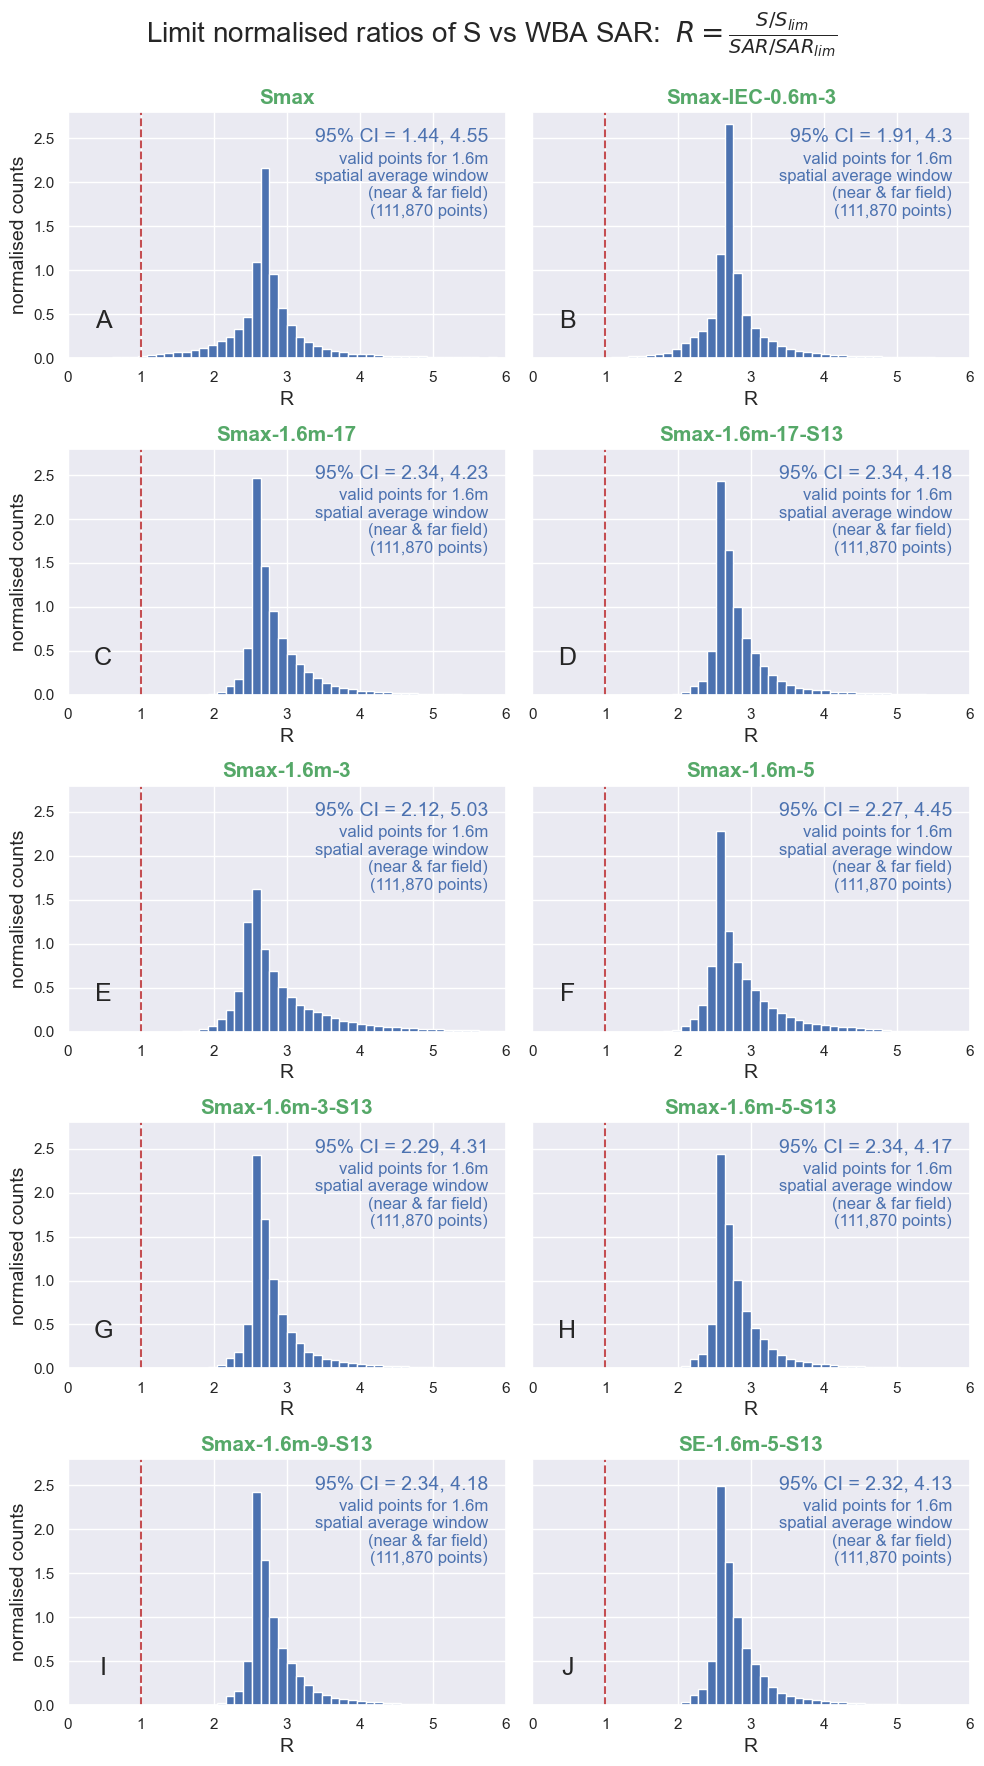

In [24]:
# Create list of fields and associated filters for R ratios
sflist = [['Smax',f_sa16nearfar],
          ['Smax-IEC-0.6m-3',f_sa16nearfar],
          ['Smax-1.6m-17',f_sa16nearfar],
          ['Smax-1.6m-17-S13',f_sa16nearfar],
          ['Smax-1.6m-3',f_sa16nearfar],
          ['Smax-1.6m-5',f_sa16nearfar],
          ['Smax-1.6m-3-S13',f_sa16nearfar],
          ['Smax-1.6m-5-S13',f_sa16nearfar],
          ['Smax-1.6m-9-S13',f_sa16nearfar],
          ['SE-1.6m-5-S13',f_sa16nearfar]]

# Generate histogram
histR(sflist,dB=False,cols=2)
plt.savefig(plotdir + 'R histogram yagi.png', dpi=150)

In [25]:
showstats(sflist,dB=False)

,Si,count,mean,std,min,2.5%,50%,97.5%,max
panel,,,,,,,,,
A,Smax,101926,2.76,0.80,0.24,1.44,2.71,4.55,100.40
B,Smax-IEC-0.6m-3,101926,2.79,0.61,0.69,1.91,2.69,4.30,41.86
C,Smax-1.6m-17,101926,2.86,0.49,1.74,2.34,2.70,4.23,18.84
D,Smax-1.6m-17-S13,101926,2.85,0.48,1.74,2.34,2.70,4.18,19.38
E,Smax-1.6m-3,101926,2.93,0.88,0.53,2.12,2.68,5.03,87.76
F,Smax-1.6m-5,101926,2.89,0.63,1.58,2.27,2.70,4.45,53.26
G,Smax-1.6m-3-S13,101926,2.85,0.60,0.60,2.29,2.69,4.31,67.09
H,Smax-1.6m-5-S13,101926,2.85,0.53,1.71,2.34,2.70,4.17,47.87
I,Smax-1.6m-9-S13,101926,2.85,0.49,1.75,2.34,2.70,4.18,27.71


#### dB(R) histograms for valid box of points

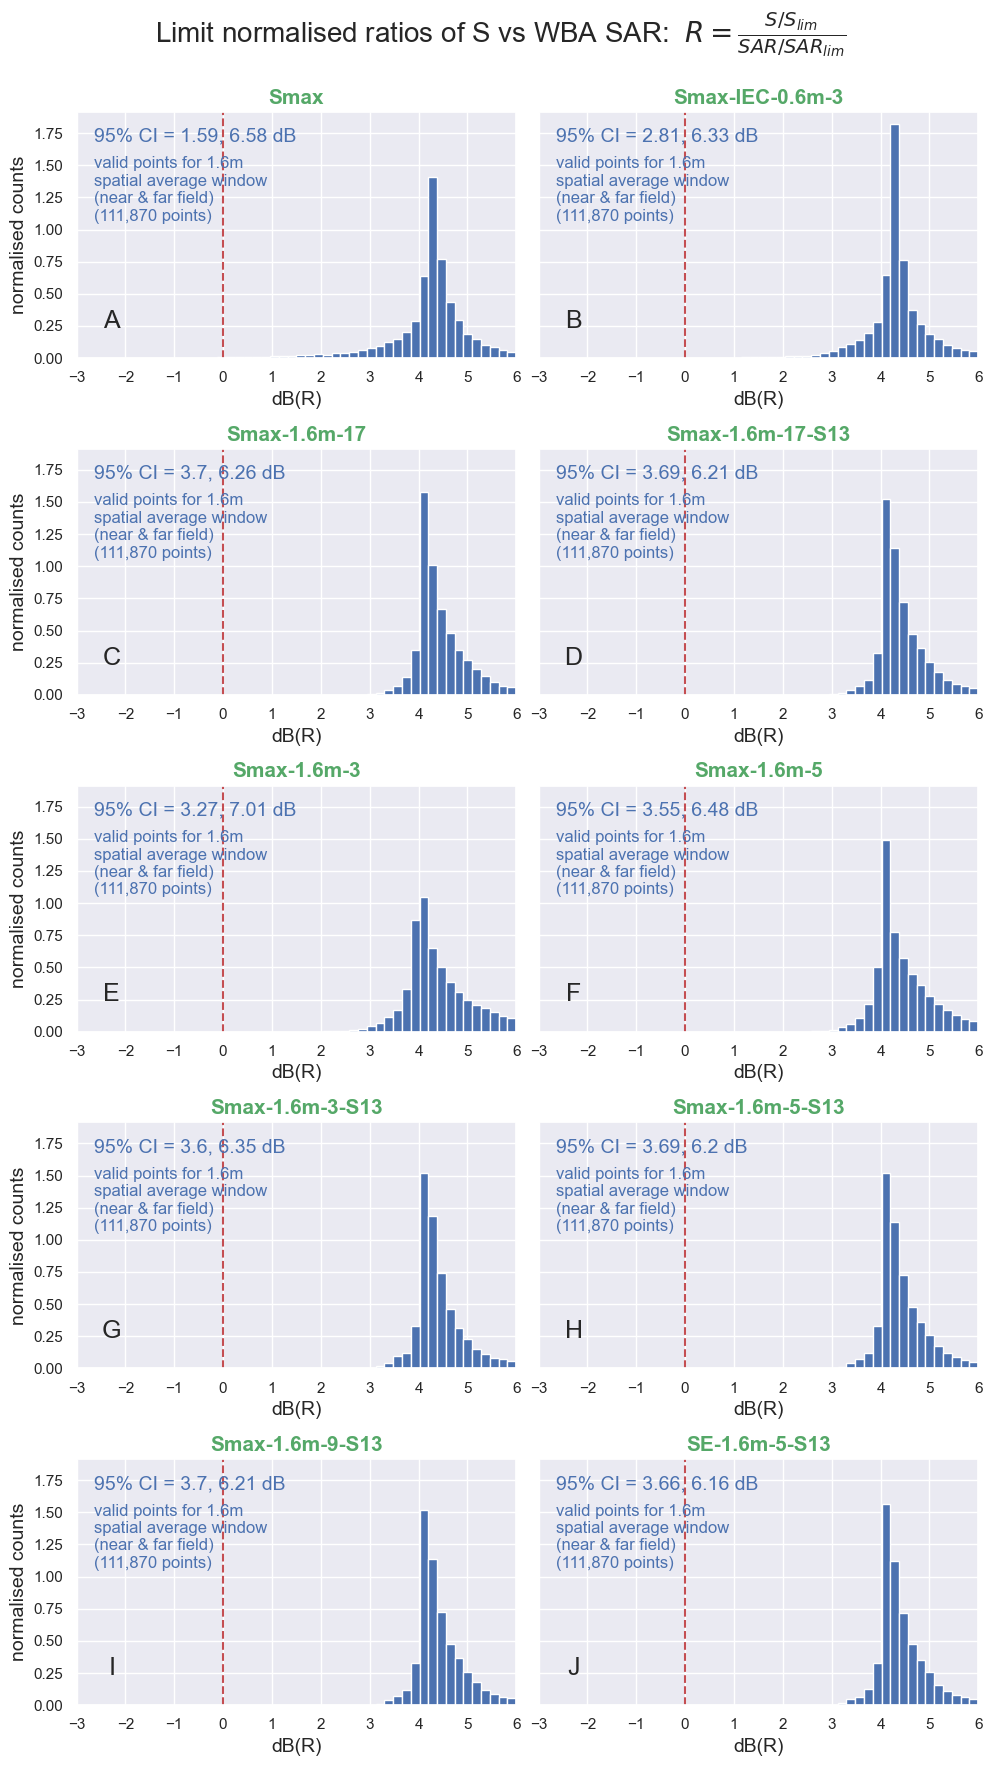

In [26]:
# dB(R) histograms for Slist
histR(sflist,dB=True,cols=2)
plt.savefig(plotdir + 'dB(R) histogram yagi.png', dpi=150)

In [87]:
showstats(sflist, dB=True)

dB data,Si,count,mean,std,min,2.5%,50%,97.5%,max
panel,,,,,,,,,
A,Smax,101926,4.28,1.10,-6.20,1.59,4.32,6.58,20.02
B,Smax-IEC-0.6m-3,101926,4.38,0.79,-1.62,2.81,4.30,6.33,16.22
C,Smax-1.6m-17,101926,4.51,0.63,2.40,3.70,4.32,6.26,12.75
D,Smax-1.6m-17-S13,101926,4.50,0.61,2.41,3.69,4.31,6.21,12.87
E,Smax-1.6m-3,101926,4.55,0.94,-2.76,3.27,4.29,7.01,19.43
F,Smax-1.6m-5,101926,4.54,0.74,1.99,3.55,4.31,6.48,17.26
G,Smax-1.6m-3-S13,101926,4.49,0.66,-2.25,3.60,4.30,6.35,18.27
H,Smax-1.6m-5-S13,101926,4.49,0.61,2.33,3.69,4.31,6.20,16.80
I,Smax-1.6m-9-S13,101926,4.49,0.61,2.43,3.70,4.31,6.21,14.43


#### R histograms for valid points in near field (<1$\lambda$)

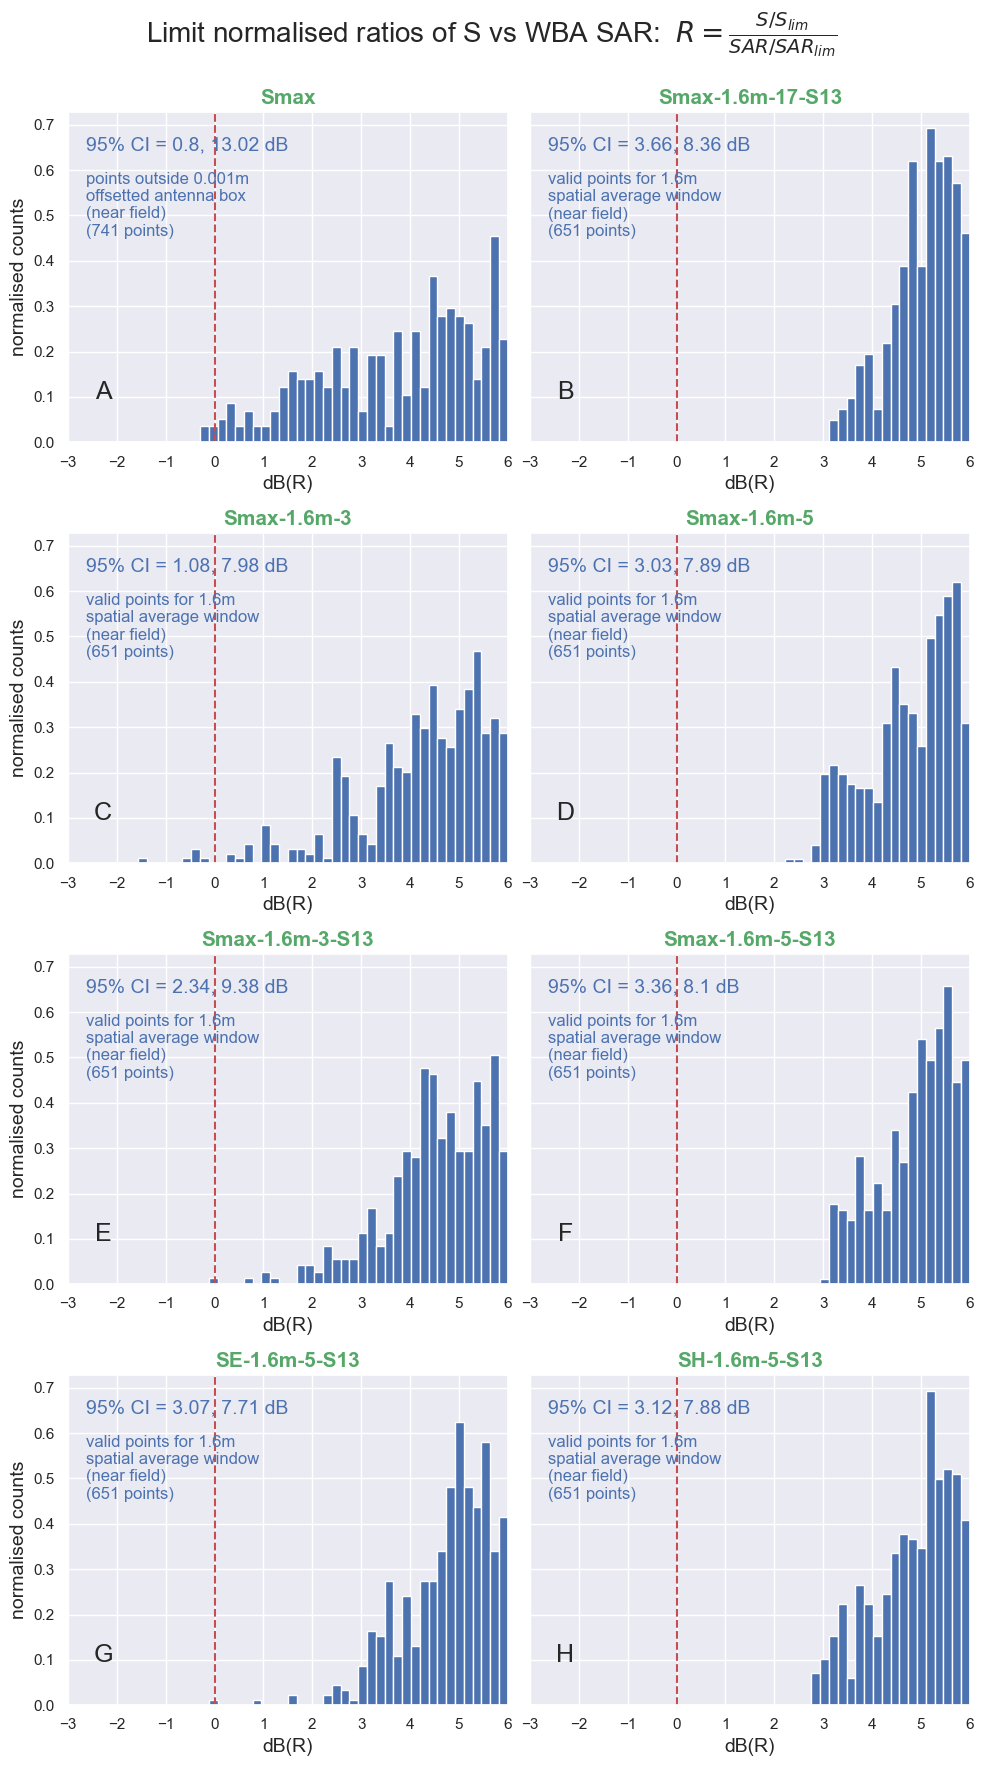

In [88]:
sflist = [['Smax',f_outantnear],
          ['Smax-1.6m-17-S13',f_sa16near],
          ['Smax-1.6m-3',f_sa16near],
          ['Smax-1.6m-5',f_sa16near],
          ['Smax-1.6m-3-S13',f_sa16near],
          ['Smax-1.6m-5-S13',f_sa16near],
          ['SE-1.6m-5-S13',f_sa16near],
          ['SH-1.6m-5-S13',f_sa16near]]

histR(sflist,dB=True,cols=2)
plt.savefig(plotdir + 'R histogram yagi near.png', dpi=150)

#### R histograms for valid points in far field (> 1$\lambda$)

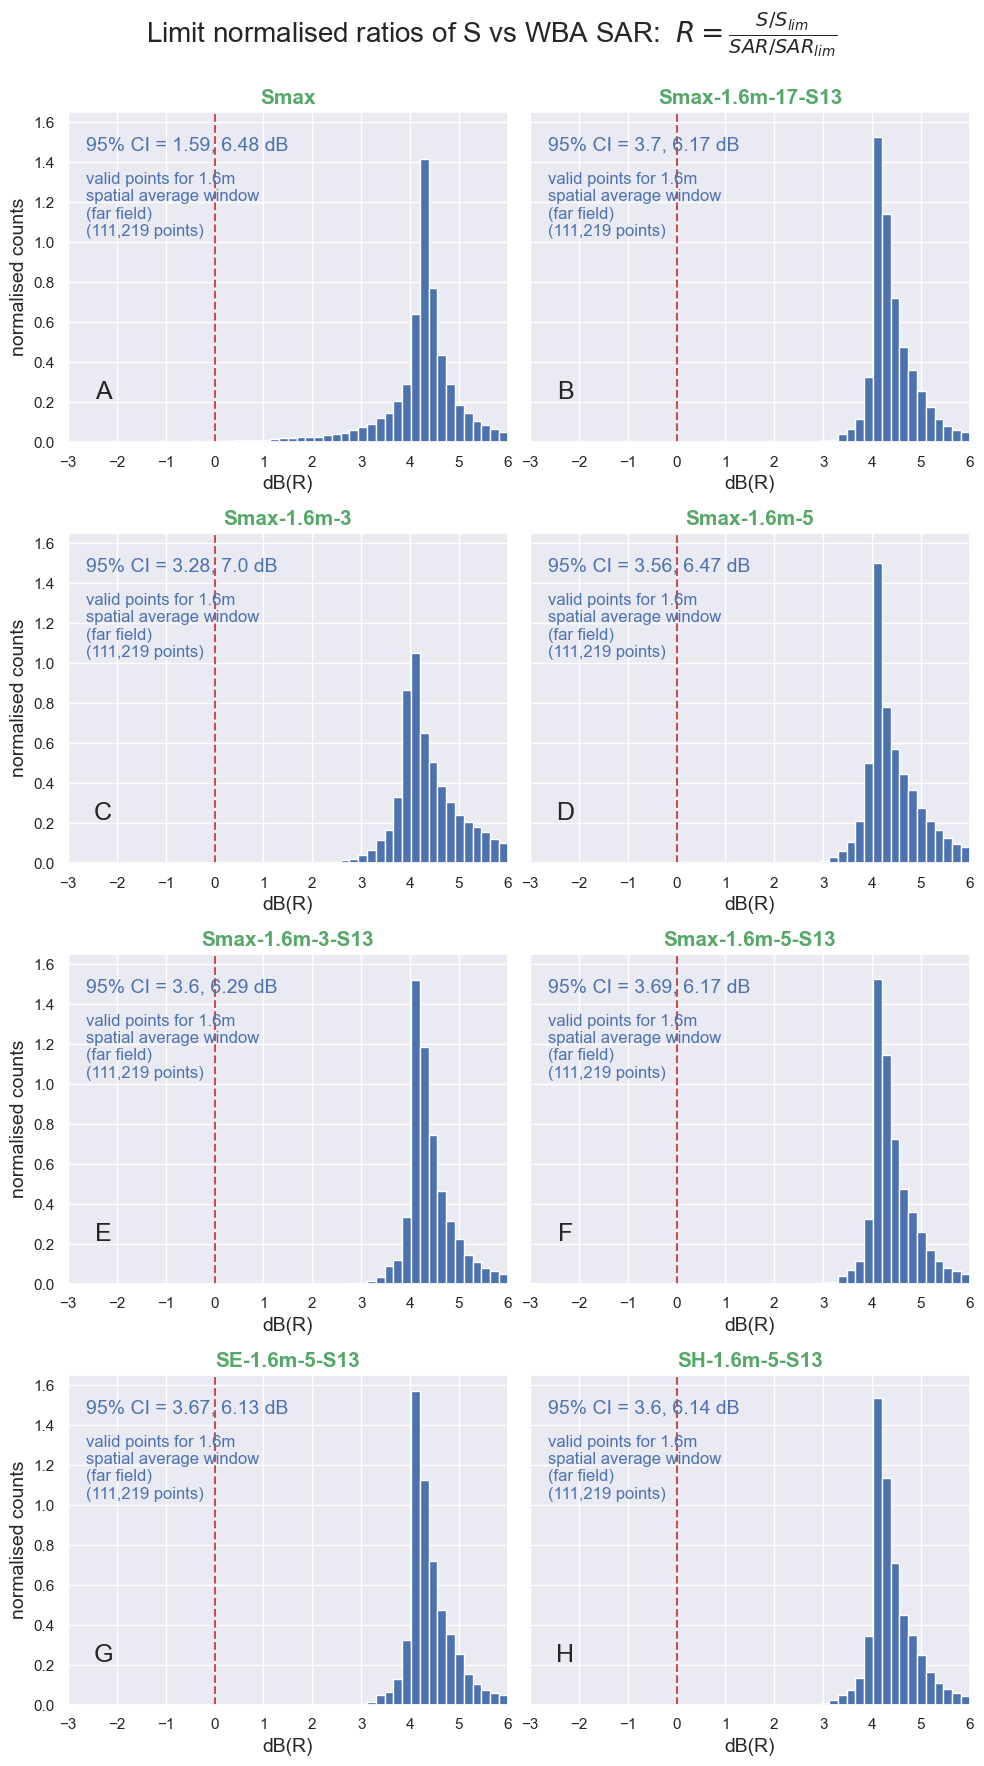

In [89]:
sflist = [['Smax',f_sa16far],
          ['Smax-1.6m-17-S13',f_sa16far],
          ['Smax-1.6m-3',f_sa16far],
          ['Smax-1.6m-5',f_sa16far],
          ['Smax-1.6m-3-S13',f_sa16far],
          ['Smax-1.6m-5-S13',f_sa16far],
          ['SE-1.6m-5-S13',f_sa16far],
          ['SH-1.6m-5-S13',f_sa16far]]

histR(sflist,dB=True,cols=2)
plt.savefig(plotdir + 'R histogram yagi near.png', dpi=150)

#### R histograms for valid points near Smax compliance boundary

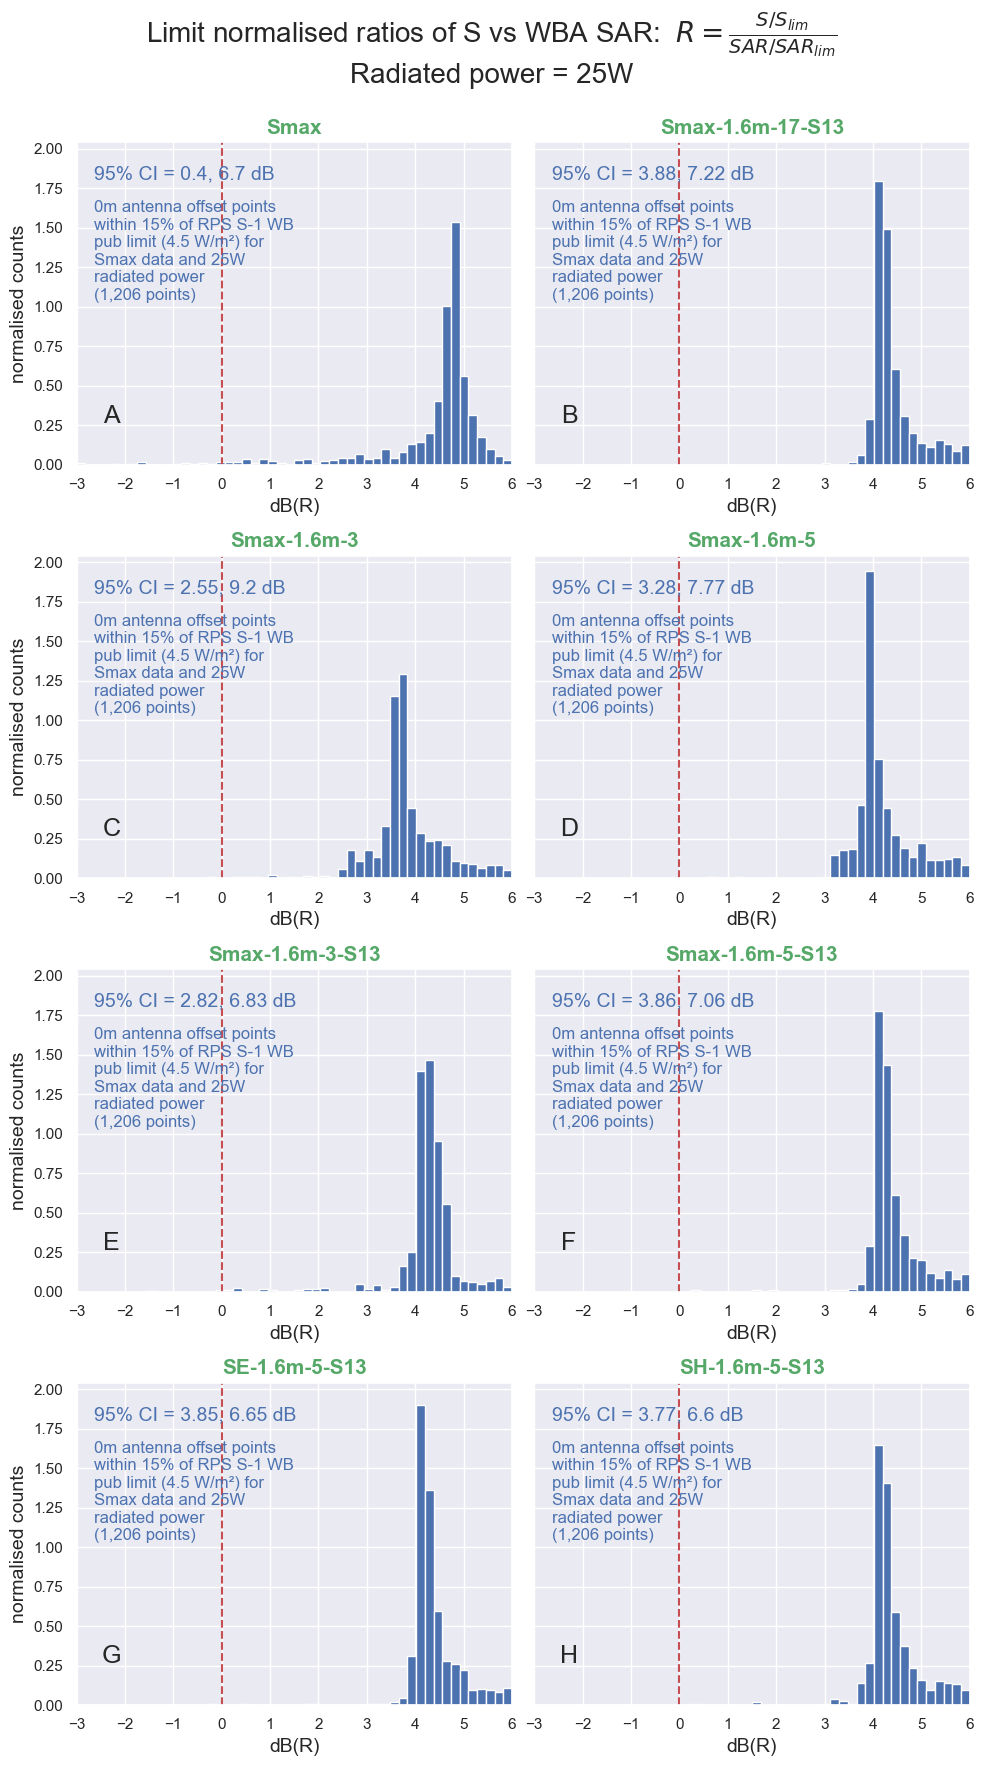

In [34]:
power = 25
f = R.sf('cb', setting='pub', data='Smax', offset=0,
           errtol=0.15, spatavgL=1.6, power=power, standard='RPS S-1 WB')
sflist_c = [['Smax',f],
            ['Smax-1.6m-17-S13',f],
            ['Smax-1.6m-3',f],
            ['Smax-1.6m-5',f],
            ['Smax-1.6m-3-S13',f],
            ['Smax-1.6m-5-S13',f],
            ['SE-1.6m-5-S13',f],
            ['SH-1.6m-5-S13',f]]

histR(sflist_c,dB=True,cols=2,power=power)
plt.savefig(plotdir + f'R histogram yagi cb {power}W.png', dpi=150)

#### R histograms for valid 1.6m points at cb and 25W <= P <= 100W

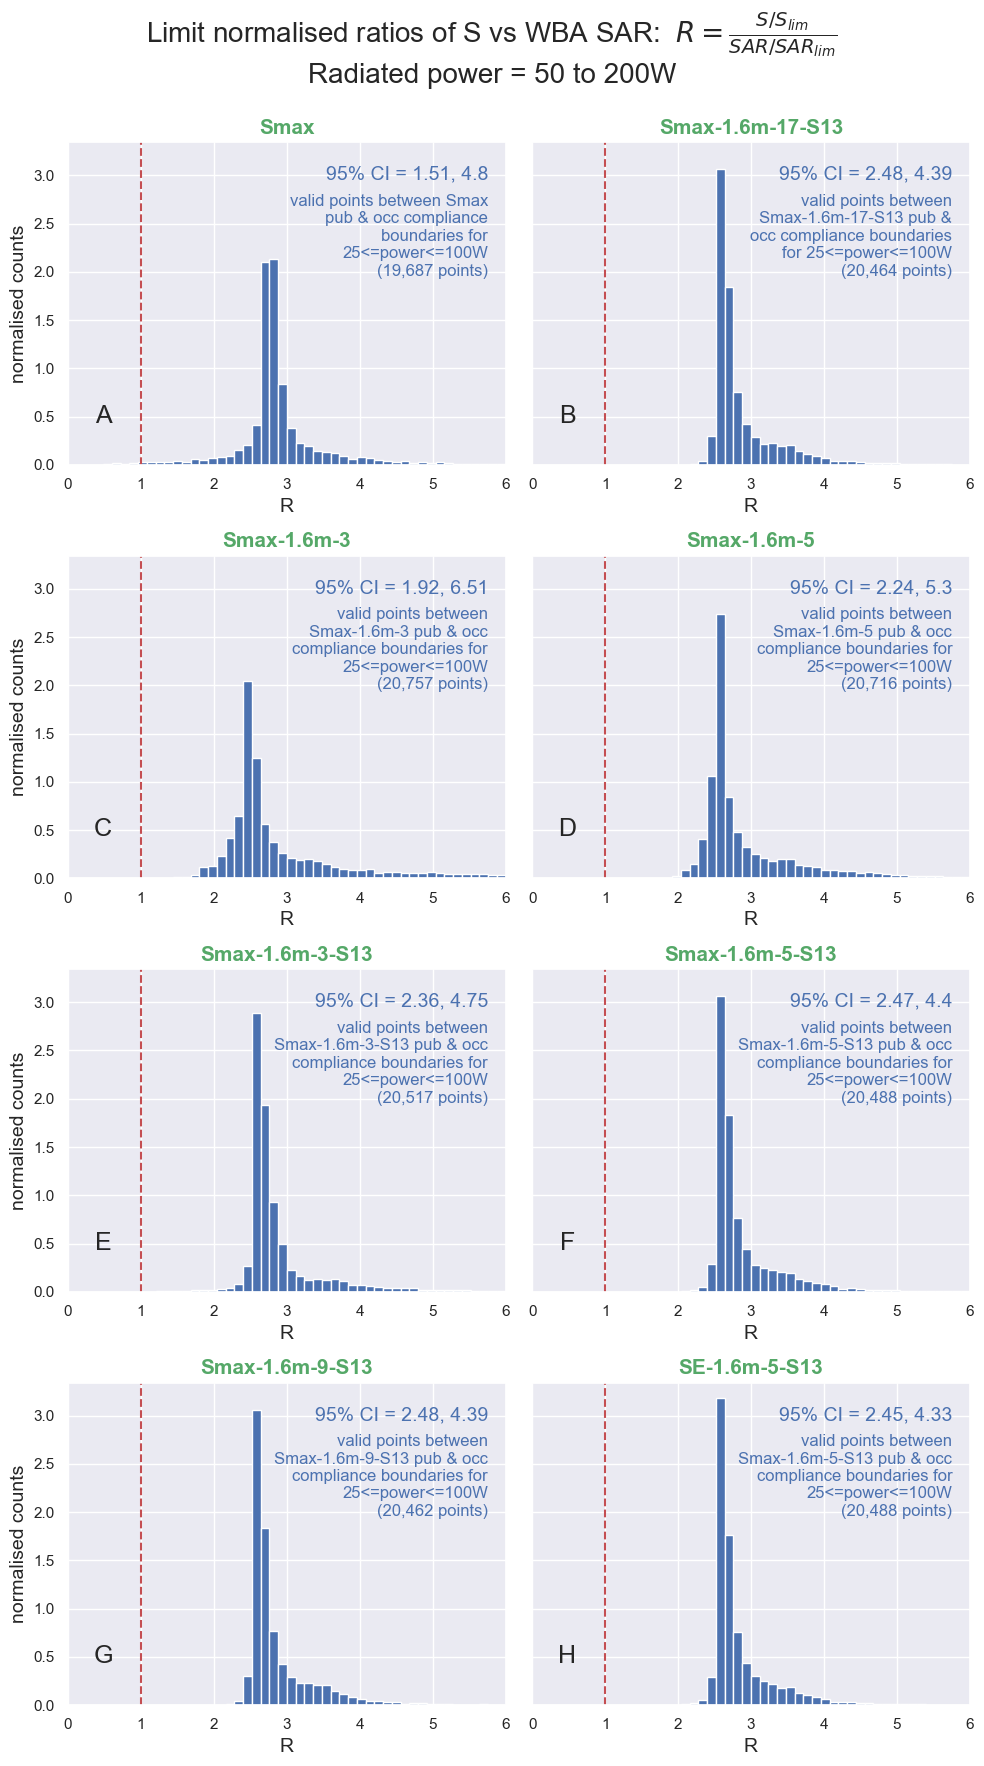

In [27]:
sflist = [['Smax',f_Smax_cb25to100W],
          ['Smax-1.6m-17-S13',f_Smax_cb25to100W_sa16_17_S13],
          ['Smax-1.6m-3',f_Smax_cb25to100W_sa16_3],
          ['Smax-1.6m-5',f_Smax_cb25to100W_sa16_5],
          ['Smax-1.6m-3-S13',f_Smax_cb25to100W_sa16_3_S13],
          ['Smax-1.6m-5-S13',f_Smax_cb25to100W_sa16_5_S13],
          ['Smax-1.6m-9-S13',f_Smax_cb25to100W_sa16_9_S13],
          ['SE-1.6m-5-S13',f_Smax_cb25to100W_sa16_5_S13]]

histR(sflist,dB=False,cols=2,power='50 to 200')
plt.savefig(plotdir + 'R histogram yagi 25 to 100W.png', dpi=150)

In [39]:
showstats(sflist,dB=False)

,Si,count,mean,std,min,2.5%,50%,97.5%,max
panel,,,,,,,,,
A,Smax,10391,2.90,0.74,0.45,1.46,2.79,4.86,11.04
B,Smax-1.6m-17-S13,20464,2.89,0.53,1.74,2.48,2.67,4.39,8.05
C,Smax-1.6m-3,20757,3.05,1.20,0.53,1.92,2.56,6.51,12.75
D,Smax-1.6m-5,20716,2.96,0.80,1.58,2.24,2.62,5.30,9.23
E,Smax-1.6m-3-S13,20517,2.89,0.62,0.60,2.36,2.67,4.75,9.15
F,Smax-1.6m-5-S13,20488,2.89,0.54,1.71,2.47,2.67,4.40,8.21
G,Smax-1.6m-9-S13,20462,2.89,0.53,1.75,2.48,2.67,4.39,8.32
H,SE-1.6m-5-S13,20488,2.87,0.52,1.00,2.45,2.67,4.33,7.65


In [97]:
# Show points between compliance boundaries
f = f_Smax_cb25to100W_sa16
f.mask = f.mask & (R.S.y >= 0)
R.msp(data='Smax', f=f, mp=1, V=[0, 100], nlabels=6, ncolors=6,
            scale=0.075, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

### R vs r

In [103]:
# Add a new r (r2) which measures distance from the centre of the yagi at x = 0.477/2 = 0.239m
R.S['r2'] = np.sqrt((R.S.x-0.2385)**2 + R.S.y**2 + R.S.z**2)
R.S[['x','y','z','r','r2']]

,x,y,z,r,r2
0,-1.0,-2.0,-3.0,2.236068,3.812333
1,-1.0,-2.0,-2.9,2.236068,3.734151
2,-1.0,-2.0,-2.8,2.236068,3.657032
3,-1.0,-2.0,-2.7,2.236068,3.581045
4,-1.0,-2.0,-2.6,2.236068,3.506263
...,...,...,...,...,...
152556,5.0,2.0,2.6,5.385165,5.782031
152557,5.0,2.0,2.7,5.385165,5.827682
152558,5.0,2.0,2.8,5.385165,5.874681
152559,5.0,2.0,2.9,5.385165,5.922996


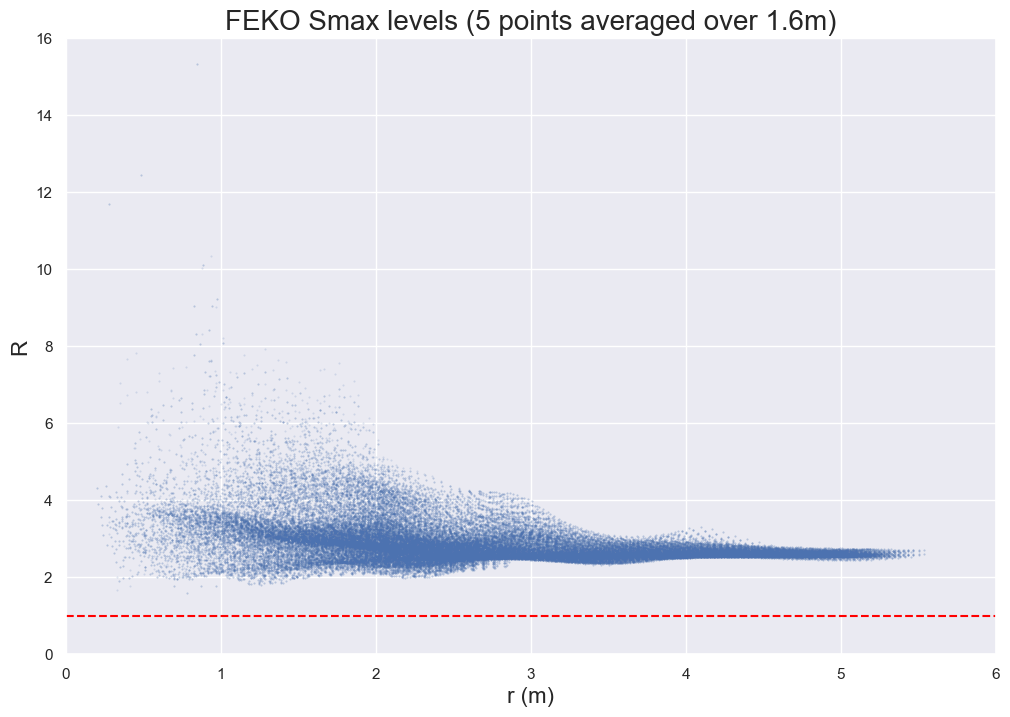

In [106]:
Si = 'Smax-1.6m-5'
f = fsa16
data = (R.S.loc[f.mask,Si]/SLIM_WB_PUB) / (R.S.loc[f.mask,'SARwbi']/SARLIM_PUB)
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r2'], y=data,alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Si],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.set_xlim((0,6))
ax.set_ylim((0,16))
ax.set_xticks(range(7))
ax.hlines(1,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'R vs r scatter ({Ssa}) valid 1.6m points yagi.png',dpi=150)

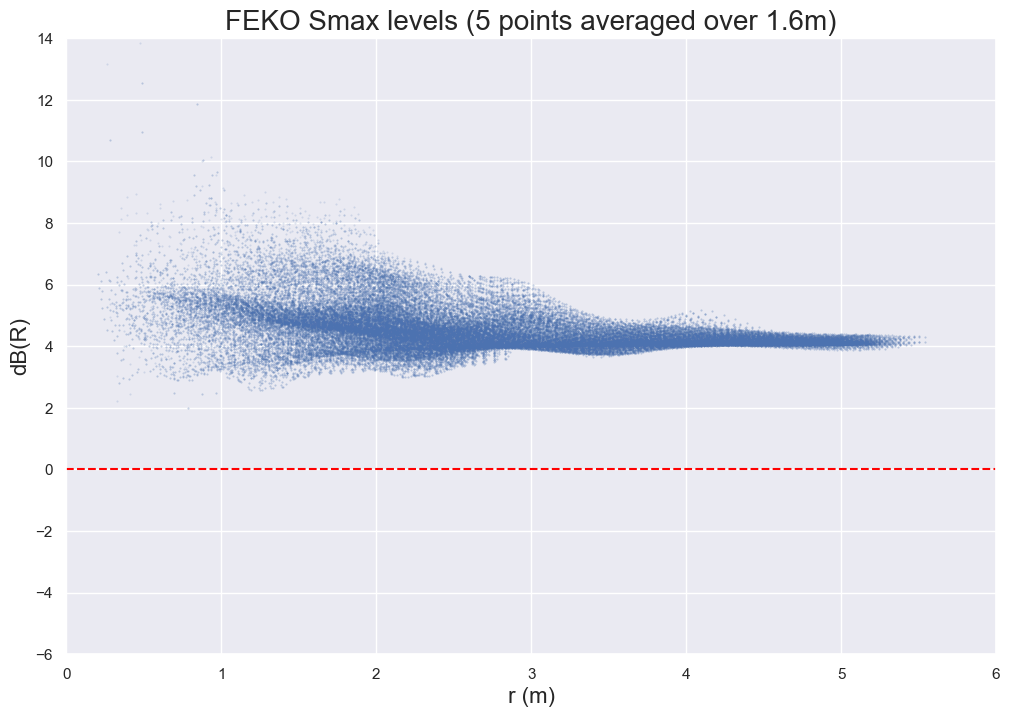

In [108]:
Si = 'Smax-1.6m-5'
f = fsa16
data = (R.S.loc[f.mask,Si]/SLIM_WB_PUB) / (R.S.loc[f.mask,'SARwbi']/SARLIM_PUB)
data = 10. * np.log10(data)
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r2'], y=data, alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Si],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('dB(R)', fontsize=16)
ax.set_xlim((0,6))
ax.set_ylim((-6,14))
ax.set_xticks(range(7))
ax.set_yticks(range(-6,15,2))
ax.hlines(0,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'dB(R) vs r scatter ({Ssa}) yagi.png',dpi=150)

## Point spatial vs spatial average uncertainty

In [ ]:
# Compare SE and SE-1.6m-5
n = 2
R.ExclusionZone(
    data=["SE","SE-1.6m-5"],
    power=[20] * n,
    color=["lightgrey","green"],
    alpha=[0.7, 0.4],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="SE vs SE-1.6m-5 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

### Create error data column in R.S

In [ ]:
# Create error data
err = R.S['SE'] / R.S['SE-1.6m-5']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-5', 'dB error for SE/SE-1.6m-5')

err = R.S['SE'] / R.S['SE-1.6m-17']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-17', 'dB error for SE/SE-1.6m-17')

err = R.S['SE-1.6m-5'] / R.S['SE-1.6m-17']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE-1.6m-5 v SE-1.6m-17', 'dB error for SE-1.6m-5/SE-1.6m-17')

In [ ]:
R.S.z.unique()

### Analyse points close to the antenna (within λ)

In [ ]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f0 = R.sf('(z >= -2.2) & (z <= 2.2)')  # exclude points that aren't properly averaged
f1 = R.sf('ant', offset=d, setting='pub', power=100)
f1.mask = f1.mask & f0.mask

# Show filter points
R.msp(data='dBerr SE v SE-1.6m-5', f=f1, mp=1, V=[-10, 10], nlabels=21, ncolors=8,
      scale=0.025, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

# Show SARwbi histogram
R.hist(data='dBerr SE v SE-1.6m-5', f=f1, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-17', f=f1, CI=95, bins=100)

### Analyse points *not* close to the antenna (further than λ)

In [ ]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f0 = R.sf('(z >= -2.2) & (z <= 2.2)')  # exclude points that aren't properly averaged
f2 = R.sf('outant', offset=d, setting='pub', power=100)
f2.mask = f2.mask & f0.mask

# Show SARwbi histogram
R.hist(data='dBerr SE v SE-1.6m-5', f=f2, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-17', f=f2, CI=95, bins=100)

# Show filter points
R.msp(data='dBerr SE v SE-1.6m-5', f=f2, mp=4, V=[-10, 10], nlabels=21, ncolors=8,
      scale=0.025, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

### Analyse points *not* close to the antenna (further than λ)

In [ ]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f2 = R.sf('outant', offset=d, setting='pub', power=100)

# Show SARwbi histogram
R.hist(data='dBerr SE-1.6m-5 v SE-1.6m-17', f=f2, CI=90, bins=100)
R.hist(data='dBerr SE-1.6m-5 v SE-1.6m-17', f=f2, CI=90, bins=100)

# Show filter points
# R.msp(data='dBerr SE v SE-1.6m-5', f=f2, mp=4, V=[-10, 10], nlabels=21, ncolors=8,
#       scale=0.025, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

## Image of compliance zone and points

In [23]:
# 3D view of public exclusion zone (200W) and all sample points
R.ExclusionZone(
    data=["SE"],
    power=[100],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="", #RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    gridpoints=True,
    antenna=RFcalcUC.hyagi,
    axv=[True,True,True],
    bg='white',
)

dat='SE', con=4.5
[-0.3, 4.6, -1.3, 1.3, -1.6, 1.8]
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500


In [37]:
sflist = [['Smax',f_Smax_cb25to100W],
          ['Smax-1.6m-17-S13',f_Smax_cb25to100W_sa16_17_S13],
          ['Smax-1.6m-3',f_Smax_cb25to100W_sa16_3],
          ['Smax-1.6m-5',f_Smax_cb25to100W_sa16_5],
          ['Smax-1.6m-3-S13',f_Smax_cb25to100W_sa16_3_S13],
          ['Smax-1.6m-5-S13',f_Smax_cb25to100W_sa16_5_S13],
          ['Smax-1.6m-9-S13',f_Smax_cb25to100W_sa16_9_S13],
          ['SE-1.6m-5-S13',f_Smax_cb25to100W_sa16_5_S13]]

# 3D view of public (200W) and occ (50W) exclusions zones
i = 0
Si = sflist[i][0]
f = sflist[i][1]
print(Si)

R.ExclusionZone(
    data=[Si, Si],
    power=[100,25],
    color=["gold", "red"],
    alpha=[1, 1],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title=f"RPS S-1 public (100 W) and occupational (25W) exclusion zones for {Si}",
    figsize=(1200,800),
    gridpoints=True,
    gridpoint_filter=f,
    gridpoint_size=0.04,
    gridpoint_opacity=1,
    antenna=RFcalcUC.hyagi,
    ycut=0,
    axv=[True,True,True],
    bg='white',
)

Smax
dat='Smax', con=4.5
dat='Smax', con=90.0
[-0.2, 4.6, -1.3, 1.3, -1.6, 1.8]
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=25, setting=occupational, limit=22.5 W/m², contour level=90.000


In [36]:
# Create plot of assessment point locations between compliance boundaries
f = f_Smax_cb25to100W
f.mask = f.mask & (R.S.y >= 0)
R.msp(data='Smax', f=f, mp=1, V=[0, 100], nlabels=6, ncolors=6,
            scale=0.075, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

In [101]:
# Show mask points
# f = f_outantnear
# f = f_outant
# f = f_outant
f = f_Smax_cb50to200W
# f = f_not_sa16
# f = f_Smax_cb50to200W_sa16
# f = f_sa16
print(f.name)
RFcalcUC.show_grid_points(R.S[f.mask], fields=['SE'],hman=None,axv=(True,True,True), ycut=False,
                          antcolor='yellow',bgcolor='white',antenna=RFcalcUC.panelAntenna,title=f.name)

valid 1.6m points at Smax pub & occ compliance boundaries for 50<=power<=200W


## Scratch

In [ ]:
def skewGrid():
    '''Show S and SAR grid points
    usage: .showgrids(S, SAR)
      S = flag to toggle S grid visibility (True/False)
    SAR = flag to toggle SAR grid visibility (True/False)
    hman = height of body model behind antenna in m
           If hman = None, then man model is not displayed
    avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
    '''
    # Make the grid
    x = [-0.8,-0.3,0.2, 0.5, 0.8, 1.3, 2, 3.2, 5, 7.3, 10, 13]
    y = [0, 0.3, 0.8, 1.6, 2.6, 4, 6]
    z = [-2,-1, 0, 1, 2]    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(900,900), bgcolor=(0.3, 0.3, 0.3))
    mlab.clf()

    # draw the SAR grid popints
    mlab.points3d(xx,yy,zz,scale_factor=0.1,color=(1,1,0),opacity=1)   # SAR grid

    # Add the antenna box
    RFcalcUC.hyagi('yellow')

    # Draw the scene
    fig.scene.parallel_projection = True
    mlab.show()
    
skewGrid()

In [ ]:
a = pd.Series([1,2,3,np.nan])
display(a)
a.mean()

In [ ]:
import numpy as np
from scipy import stats
np.random.seed(9)

my_data = stats.norm.rvs(size=1000)
plt.hist(my_data,bins=20);
stats.kstest(my_data, 'norm')

In [ ]:
R.S['SARwbi'].dropna().size

### Mayavi animations

In [ ]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

In [ ]:
import numpy as np
from mayavi import mlab
x, y = np.mgrid[0:3:1,0:3:1]
s = mlab.surf(x, y, np.asarray(x*0.1, 'd'))

@mlab.animate
def anim():
    for i in range(10):
        s.mlab_source.scalars = np.asarray(x*0.1*(i+1), 'd')
        yield

anim()
mlab.show()

In [ ]:
# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

# View it.
l = mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')

# Now animate the data.
ms = l.mlab_source
for i in range(10):
    x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer + np.pi*(i+1)/5.)*0.5)
    scalars = np.sin(mu + np.pi*(i+1)/5)
    ms.trait_set(x=x, scalars=scalars)
    
mlab.show()

In [ ]:
from mayavi import mlab
@mlab.animate(delay=100, ui=False)
def anim():
    f = mlab.gcf()
    while 1:
        f.scene.camera.azimuth(2)
        f.scene.render()
        yield

a = anim() # Starts the animation.
mlab.show()

In [ ]:
import numpy as np
from mayavi import mlab

@mlab.animate(delay = 100)
def updateAnimation():
    t = 0.0
    while True:
        ball.mlab_source.set(x = np.cos(t), y = np.sin(t), z = 0)
        t += 0.1
        yield

ball = mlab.points3d(np.array(1.), np.array(0.), np.array(0.))

updateAnimation()
mlab.show()

In [ ]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

@mlab.animate(delay = 50)
def updateAnimation():
    az = 0.0
    while True:
        mlab.view(azimuth=az, elevation=70,distance=10)
        az += 1
        yield

# View it.
fig = mlab.figure(1, size=(900,900), bgcolor=(1,1,1))
mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')
updateAnimation()
mlab.show()

### Fast start

In [ ]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# Set trial number
trial = 2
t = trials[str(trial)]

# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)

# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print()
print(*R.grid.items(),sep='\n')
print()
R.S.info()

In [ ]:
# test filter options
fname = 'outant'
fname = 'spatavg_outant'
fname = 'all'
fname = 'ant'
fname = 'cb'
fname = 'icb'

f = R.sf(fname,offset=0.7,spatavgL=1.6)
df = R.S[f.mask]
RFcalcUC.show_grid_points(df, fields=['Smax'],hman=1.6,axv=(True,True,True),
                          antenna=RFcalcUC.panelAntenna,title='')